# 6 节点最大割问题求解
## 主程序 0：先画出 6 节点的图，每个节点有 3 条边。并采用经典穷举法，计算其最大切割边数。

one size: [0] cut= 3
one size: [1] cut= 3
one size: [1, 0] cut= 4
one size: [2] cut= 3
one size: [2, 0] cut= 6
one size: [2, 1] cut= 4
one size: [2, 1, 0] cut= 5
one size: [3] cut= 3
one size: [3, 0] cut= 4
one size: [3, 1] cut= 6
one size: [3, 1, 0] cut= 5
one size: [3, 2] cut= 4
one size: [3, 2, 0] cut= 5
one size: [3, 2, 1] cut= 5
one size: [4] cut= 3
one size: [4, 0] cut= 6
one size: [4, 1] cut= 4
one size: [4, 1, 0] cut= 5
one size: [4, 2] cut= 6
one size: [4, 2, 0] cut= 9
one size: [4, 2, 1] cut= 5
one size: [4, 3] cut= 4
one size: [4, 3, 0] cut= 5
one size: [4, 3, 1] cut= 5
one size: [4, 3, 2] cut= 5
one size: [5] cut= 3
one size: [5, 0] cut= 4
one size: [5, 1] cut= 6
one size: [5, 1, 0] cut= 5
one size: [5, 2] cut= 4
one size: [5, 2, 0] cut= 5
one size: [5, 2, 1] cut= 5
one size: [5, 3] cut= 6
one size: [5, 3, 0] cut= 5
one size: [5, 3, 1] cut= 9
one size: [5, 3, 2] cut= 5
one size: [5, 4] cut= 4
one size: [5, 4, 0] cut= 5
one size: [5, 4, 1] cut= 5
one size: [5, 4, 2] cut= 5
o

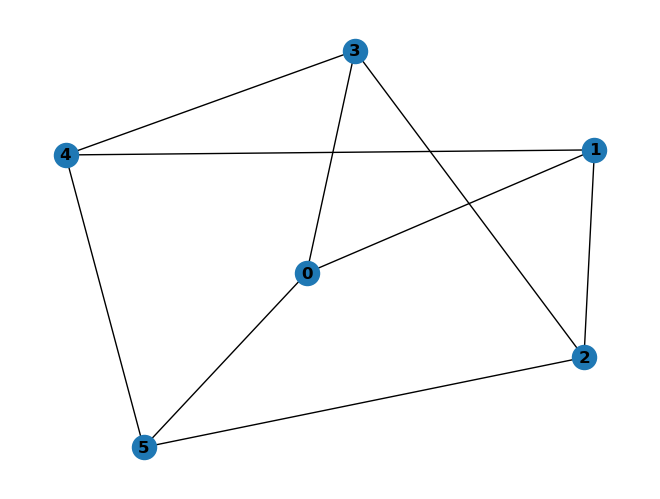

In [1]:
import networkx as nx

g_6 = nx.Graph()
nx.add_path(g_6, [0, 1])
nx.add_path(g_6, [1, 2])
nx.add_path(g_6, [2, 3])
nx.add_path(g_6, [3, 4])
nx.add_path(g_6, [4, 5])
nx.add_path(g_6, [5, 0])
nx.add_path(g_6, [0, 3])
nx.add_path(g_6, [1, 4])
nx.add_path(g_6, [2, 5])
nx.draw(g_6, with_labels=True, font_weight='bold') # 画出图

for i in g_6.nodes:
    print('one size:', [i], 'cut=', nx.cut_size(g_6, [i]))            # 一组 1 个节点、另一组 5 个节点的所有情况
    for j in range(i):
        print('one size:', [i, j], 'cut=', nx.cut_size(g_6, [i, j]))  # 一组 2 个节点、另一组 4 个节点的所有情况
        for k in range(j):
            print('one size:', [i, j, k], 'cut=', nx.cut_size(g_6, [i, j, k]))  # 一组 3 个节点、另一组 3 个节点的所有情况

从上面结果可以看出，穷举法得到的最大割边数为 9。如果对节点分组的左右进行区分，则一共有 2 种分组方法可以使切割边数最大，即该问题有 2 个简并解，即： \[4, 2, 0 | 5, 3, 1\] 和 \[5, 3, 1 | 4, 2, 0\]。

## 主程序 1：用论文方案求解 6 节点图

train step: 0 , cut: 4.1677275
train step: 50 , cut: 8.911496
train step: 100 , cut: 8.970087
train step: 150 , cut: 8.9841175
train step: 200 , cut: 8.987491
train step: 250 , cut: 8.98653
train step: 300 , cut: 8.485818
train step: 350 , cut: 8.986066
train step: 400 , cut: 8.988697
train step: 450 , cut: 8.989105

采用最终参数下，预期切割边数： 8.98956867790491


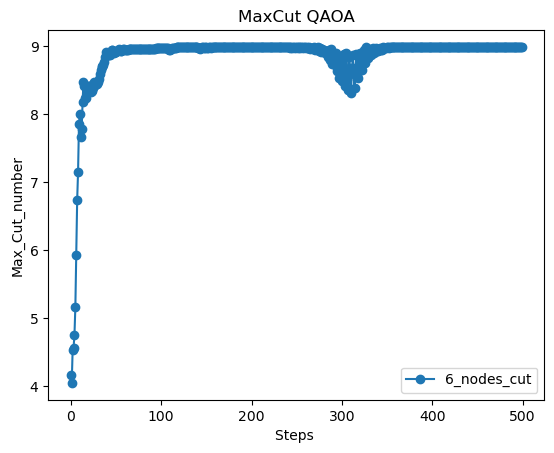

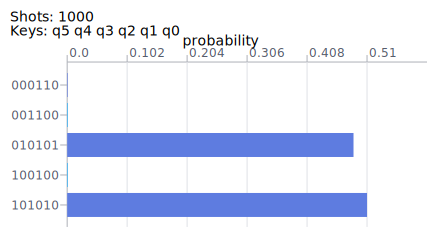

In [4]:
import numpy as np
import mindspore as ms
from mindquantum import *
import matplotlib.pyplot as plt
from mindspore import context, nn, Parameter, Tensor
from mindspore.common.initializer import initializer
context.set_context(mode=context.PYNATIVE_MODE, device_target='CPU')
np.random.seed(1)
ms.set_seed(1)

# 构建量子线路
def build_hc(g, para): # 对图中的每条边作用 ZZ 门
    hc = Circuit()
    for i in g.edges:
        hc += Rzz(para).on(i)
    return hc

def build_hb(g, para): # 对图中的每个节点作用 RX 门
    hb = Circuit()
    for i in g.nodes:
        hb += RX(para).on(i)
    return hb

def build_ansatz(g, num_layer):   # g 是 max-cut 问题的图，num_layer 是 ansatz 线路的层数
    circ = Circuit()
    for i in range(num_layer):
        circ += build_hc(g, f'g{i}')       # 添加 Uc 对应的线路，参数记为 g0、g1、g2...
        circ += build_hb(g, f'b{i}')       # 添加 Ub 对应的线路，参数记为 b0、b1、b2...
    return circ

def build_ham(g):
    ham = QubitOperator()
    for i in g.edges:
        ham += QubitOperator(f'Z{i[0]} Z{i[1]}')  # 生成哈密顿量 Hc
    return ham

num_layer = 7
ham = Hamiltonian(build_ham(g_6))      # 生成哈密顿量
init_state_circ = UN(H, g_6.nodes)         # 生成均匀叠加态，即对所有量子比特作用H门
ansatz = build_ansatz(g_6, num_layer)   # 生成拟设线路
circ = init_state_circ + ansatz.as_encoder()                  # 将初始化线路与拟设线路组合成总的线路

sim = Simulator('mqvector', circ.n_qubits) # 创建模拟器
grad_ops = sim.get_expectation_with_grad(ham, circ)

# 采用一个 LSTM 作为对量子线路参数的经典优化器
# LSTM 输入为量子线路旧的参数，输出作为量子线路新的参数。
class TrainableLSTM(nn.Cell):
    def __init__(self):
        super(TrainableLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=len(circ.params_name),
                                            hidden_size=len(circ.params_name),
                                            num_layers=1,
                                            has_bias=True,
                                            batch_first=False,
                                            bidirectional=False)
        self.hidden_size = self.lstm.hidden_size
        self.batch_size = 1
        self.num_layers = 1
        self.hx = (Parameter(initializer( 'normal', shape=[self.num_layers, self.batch_size, self.hidden_size], dtype=ms.float32), name='h'),
                         Parameter(initializer('normal', shape=[self.num_layers, self.batch_size, self.hidden_size], dtype=ms.float32), name='c'))

    def construct(self, x):
        _, (x, _) = self.lstm(x, self.hx)
        return x

# LSTM 层的损失函数为量子线路最终的期望值。
class All_Net(nn.Cell):
    def __init__(self, grad_ops, init_paras):
        super(All_Net, self).__init__()
        self.lstm = TrainableLSTM()
        self.qnn_ops = MQEncoderOnlyOps(grad_ops) # 量子线路的参数不直接参与训练
        self.init_paras = init_paras
        self.squeeze = ms.ops.Squeeze(0)

    def construct(self):  # x 为量子线路旧的网络参数， out 为量子线路新的参数
        self.init_paras = self.lstm(self.init_paras)
        x = self.squeeze(self.init_paras)
        out = self.qnn_ops(x)
        return out

paras = Tensor(np.random.random([1, 1, len(circ.params_name)]).astype(np.float32))  # 量子线路初始参数
all_net = All_Net(grad_ops, paras)
opt = nn.Adam(all_net.trainable_params(),  learning_rate=0.1)  # 对 LSTM 层的参数，采用 Adam 进行优化
train_net = nn.TrainOneStepCell(all_net, opt)
train_net.set_train()

# 获取训练过程数据
cut_data = []
steps = 500
for step in range(steps):
    cut = (len(g_6.edges) - train_net()) / 2      # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步
    cut_data.append(cut.asnumpy()[0,0])
    if step %50 == 0:
        print("train step:", step, ", cut:", cut[0,0])  # 每训练 50 步，打印当前训练步数和当前得到的切割边数

sim.reset()
sim.apply_circuit(circ, pr=all_net.init_paras[0,0].asnumpy())
result = sim.get_expectation(ham).real
print('\n采用最终参数下，预期切割边数：',  (len(g_6.edges) - result) / 2)

plt.figure()
plt.plot(cut_data, label = '6_nodes_cut', linestyle='-', marker='o') # 画出训练过程中，切割边数的变化情况
plt.title('MaxCut QAOA', fontsize=12)
plt.legend()
plt.xlabel('Steps ', fontsize=10)
plt.ylabel('Max_Cut_number', fontsize=10)
plt.savefig('./src/6_nodes.png')
plt.show()

# 我们将最优参数代入量子线路，通过对量子线路进行1000次采样，画出最终量子态在计算基矢下的概率分布：
sim.reset()
pr = dict(zip(ansatz.params_name, all_net.init_paras[0,0].asnumpy()))
circ.measure_all()                                      # 为线路中所有比特添加测量门
sim.sampling(circ, pr=pr, shots=1000).svg()      # 运行线路1000次并打印结果

根据概率分布图我们发现，该 6 节点的 Max-Cut 问题具有 2 个简并解，每个解对应的概率大概为 50%。

`010101`：编号 1、3、5 的节点在左边，编号 0、2、4 的节点在右边。

`101010`：编号 0、2、4  的节点在左边，编号 1、3、5 的节点在右边。

该结果和经典穷举法的结果一致。